imports

In [26]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as k
import tensorflow as tf
from tensorflow.keras import losses

Sampling layer which is called later in the function, takes in mean and log_var and randomly samples the coding from normal distribution.

In [27]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return k.random_normal(tf.shape(log_var)) * k.exp(log_var/2) + mean

In [28]:
codings_size = 10

encoder, mean and log_var take in same input from second layer hense not being sequential

In [29]:
inputs = layers.Input(shape=[256,188])
z = layers.Flatten()(inputs)
z = layers.Dense(150, activation='selu')(z)
z = layers.Dense(100, activation='selu')(z)
codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean,codings_log_var])
variational_encoder = Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder

In [30]:
decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation='selu')(decoder_inputs)
x = layers.Dense(150, activation='selu')(x)
x = layers.Dense(256 * 188, activation='sigmoid')(x)
outputs = layers.Reshape([256, 188])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

In [31]:
_,_,codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

custom KL Loss

In [32]:
loss=losses.kullback_leibler_divergence

In [33]:
latent_loss = -0.5 * k.sum(
1 + codings_log_var - k.exp(codings_log_var) - k.square(codings_mean),
axis=-1)
variational_ae.add_loss(k.mean(latent_loss)/256*188)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [34]:
from tensorflow.keras.callbacks import EarlyStopping


In [35]:
es = EarlyStopping(patience=10,restore_best_weights=True)

history = variational_ae.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=[X_valid, X_valid], callbacks=[es])

Epoch 1/100
16/16 [==============================] - 5s 245ms/step - loss: 323574279700480.0000 - val_loss: 2987.6580
Epoch 2/100
16/16 [==============================] - 4s 230ms/step - loss: 266337.4375 - val_loss: 944.7698
Epoch 3/100
16/16 [==============================] - 4s 227ms/step - loss: 65697.5781 - val_loss: 746.9955
Epoch 4/100
16/16 [==============================] - 4s 226ms/step - loss: 53173.1719 - val_loss: 606.9963
Epoch 5/100
16/16 [==============================] - 4s 227ms/step - loss: 46067.1914 - val_loss: 491.2779
Epoch 6/100
16/16 [==============================] - 4s 229ms/step - loss: 40220.3945 - val_loss: 402.4151
Epoch 7/100
16/16 [==============================] - 4s 229ms/step - loss: 34852.1289 - val_loss: 309.2079
Epoch 8/100
16/16 [==============================] - 4s 227ms/step - loss: 26904.4238 - val_loss: 52.5173
Epoch 9/100
16/16 [==============================] - 4s 229ms/step - loss: 467.6261 - val_loss: 27.4166
Epoch 10/100
16/16 [=========

In [36]:
codings = tf.random.normal(shape=[10, codings_size])
images = variational_decoder(codings).numpy()

In [37]:
images[0].shape

(256, 188)

In [38]:
variational_ae.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 188)]   0           []                               
                                                                                                  
 model_3 (Functional)           [(None, 10),         7236470     ['input_3[0][0]']                
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 model_4 (Functional)           (None, 256, 188)     7283578     ['model_3[0][2]']                
                                                                                            

In [14]:
import numpy as np
from glob import glob

In [11]:
data_dir = '/Users/felixm/Downloads/First_Kick_Spectrograms/'

In [15]:
audiofiles = glob(data_dir + '/*.wav.npy')

In [16]:
def load_data(path):
    X = []
    
    audiofiles = glob(data_dir + '/*.wav.npy')
    
    for file in audiofiles:
        
        X.append(np.load(file))
        
        
    return np.array(X)

In [17]:
data = load_data(data_dir)

In [18]:
X_train = data[:2000, :, :]

In [19]:
X_valid = data[2000:2500, :, :]

In [21]:
import librosa.display
import IPython

In [40]:
hop_length = 300
win_length = 1200
spec = librosa.db_to_amplitude(images[1])

In [41]:
signal = librosa.istft(spec, n_fft=1200, hop_length=hop_length, win_length=win_length, dtype='float32')

In [42]:
IPython.display.Audio(signal, rate=48000)

In [ ]:
librosa.display.waveshow(signal,sr=48000)

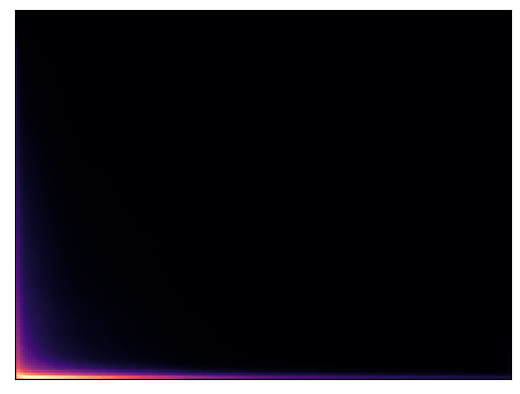

In [45]:
librosa.display.specshow(images[9])

In [46]:
import numpy as np

In [50]:
np.save("/Users/felixm/Downloads/",images)